In [1]:
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

sys.path.insert(0, '/Users/Kwat/binf/cca')
import ccal

%matplotlib inline

==================== Computational Cancer Analysis Library ====================

<13:30:50.080581> Checking dependencies ...
<13:30:50.082700> Using the following packages:
<13:30:50.084362> 	matplotlib (v1.5.1)
<13:30:50.084380> 	numpy (v1.10.4)
<13:30:50.084388> 	pandas (v0.18.0)
<13:30:50.084409> 	rpy2 (v2.7.9)
<13:30:50.084416> 	scikit-learn (v0.17.1)
<13:30:50.084423> 	scipy (v0.17.0)
<13:30:50.084430> 	seaborn (v0.7.0)


# Make test data

In [2]:
nrow = 50
nrow_2 = nrow + 30
ncol = 200
ncol_2 = ncol + 30

row_names = ['feature {}'.format(i) for i in range(nrow)]
row_names_2 = ['feature {}'.format(i) for i in range(nrow_2)]
col_names = ['elemenet {}'.format(i) for i in range(ncol)]
col_names_2 = ['elemenet {}'.format(i) for i in range(ncol_2)]

features = pd.DataFrame(np.random.random((nrow_2, ncol_2)),
                        index=row_names_2,
                        columns=col_names_2)
scores = pd.DataFrame(np.random.rand(nrow), index=row_names, columns=['p-value'])

ref_type = 'categorical'
if ref_type == 'continuous':
    ref = pd.DataFrame(np.random.rand(ncol), index=col_names, columns=['Reference']).T
else:
    if ref_type == 'categorical':
        n_category = 6
    elif ref_type == 'binary':
        n_category = 1
    ref = pd.DataFrame(np.random.random_integers(0, n_category, ncol), index=col_names, columns=['Reference']).T

# Load data

In [3]:
features = ccal.support.read_gct('../../data/test/HNSCC_PATHWAYS.v2.gct')
refs = ccal.support.read_gct('../../data/test/additional_YAP_signatures.gct')

# Make functions

In [4]:
verbose_print = ccal.support.verbose_print
information_coefficient = ccal.information.information_coefficient
establish_path = ccal.support.establish_path

CMAP_CONTINUOUS = ccal.visualize.CMAP_CONTINUOUS
CMAP_CATEGORICAL = ccal.visualize.CMAP_CATEGORICAL
FONT20_BOLD = ccal.visualize.FONT20_BOLD
FONT16_BOLD = ccal.visualize.FONT16_BOLD
FONT12_BOLD = ccal.visualize.FONT12_BOLD
FONT12 = ccal.visualize.FONT12
BLACK = ccal.visualize.BLACK
ref_type = 'continuous'
output_directory = '../../data/features'

In [5]:
def rank_features_against_references(features, refs, metric, ref_type='continuous', relationship='direct',
                                     sort_ref=True, n_features_to_plot=50, output_directory=None):
    """
    Compute features vs. each ref in `refs`.
    :param features: pandas DataFrame (n_features, m_elements), must have indices and columns
    :param refs: pandas DataFrame (n_features, m_elements), must have indices and columns, which must match 'features`'s
    :param metric: str, {information}
    :param relationship: str, {direct, inverse}
    :param ref_type: str, {continuous, categorical, binary}
    :param sort_ref: bool, sort each ref or not
    :param n_features_to_plot: int, number of top features to plot
    :param output_directory: str, directory path to save the result (.txt) and figure (.TODO)
    :return: None
    """
    if output_directory:
        establish_path(os.path.abspath(output_directory))

    for i, (idx, ref) in enumerate(refs.iterrows()):
        verbose_print('features vs. {} ({}/{}) ...'.format(idx, i + 1, refs.shape[0]))

        # Use only the intersecting columns
        col_intersection = set(features.columns) & set(ref.index)
        verbose_print(
            'Using {} intersecting columns from features and ref, which have {} and {} columns respectively ...'.format(
                len(col_intersection), features.shape[1], ref.size))
        features = features.ix[:, col_intersection]
        ref = ref.ix[col_intersection]

        # Sort ref and features
        # TODO: check the relationship logic
        if sort_ref:
            ref = ref.sort_values(ascending=(relationship == 'inverse'))
        features = features.reindex_axis(ref.index, axis=1)

        # Compute scores, join them in features, and rank features based on scores
        scores = compute_against_reference(features, ref, metric)
        features = features.join(scores)
        # TODO: decide what metric to sort by
        features.sort_values(features.columns[-1], ascending=False, inplace=True)

        # Plot features panel
        verbose_print('Plotting top {} features vs. ref ...'.format(n_features_to_plot))
        plot_features_and_reference(pd.DataFrame(features.ix[:n_features_to_plot, features.columns[:-1]]),
                                    ref,
                                    pd.DataFrame(features.ix[:n_features_to_plot, features.columns[-1]]),
                                    ref_type=ref_type, output_directory=output_directory)
        if output_directory:
            features.to_csv(os.path.join(output_directory, '{}.txt'.format(ref.name)), sep='\t')


def compute_against_reference(features, ref, metric):
    """
    Compute scores[i] = `features`[i] vs. `ref` with computation using `metric`.
    :param features: pandas DataFrame (n_features, m_elements), must have indices and columns
    :param ref: pandas Series (m_elements), must have indices, which must match 'features`'s columns
    :param metric: str, {information}
    :return: pandas DataFrame (n_features, 1),
    """
    # Compute score[i] = <features>[i] vs. <ref>
    if 'information' in metric:
        # TODO: return Series
        return pd.DataFrame([information_coefficient(ref, row[1]) for row in features.iterrows()],
                            index=features.index, columns=['information'])
    else:
        raise ValueError('Unknown metric {}.'.format(metric))

def plot_features_and_reference(features, ref, scores, ref_type='continuous', output_directory=None):
    """
    Plot a heatmap panel.
    :param features: pandas DataFrame (n_features, m_elements), must have indices and columns
    :param ref: pandas Series (m_elements), must have indices, which must match 'features`'s columns
    :param scores:  pandas DataFrame (n_features, 1), must have the same index and columns
    :param ref_type: str, {continuous, categorical, binary}
    :param output_directory: str, directory path to save the figure
    :return: None
    """
    features_nrow, features_ncol = features.shape

    # Initialize figure
    if features_ncol > 30 or features_nrow > 50:
        fig_width, fig_height = 9, 16
    else:
        fig_width, fig_height = 5, 10
    fig = plt.figure(figsize=(fig_width, fig_height), dpi=900)
    text_margin = 0.2

    # Set heatmap parameters for ref
    if ref_type == 'binary':
        ref_cmap = CMAP_BINARY
        ref_min, ref_max = 0, 1
    elif ref_type == 'categorical':
        ref_cmap = CMAP_CATEGORICAL
        ref_min, ref_max = 0, np.unique(ref.values).size
    elif ref_type == 'continuous':
        ref_cmap = CMAP_CONTINUOUS
        ref_min, ref_max = -2.5, 2.5
        # Normalize continuous values
        ref = (ref - np.mean(ref.ix[0, :])) / np.std(ref.ix[0, :])
    else:
        raise ValueError('Unknown ref_type {}.'.format(ref_type))

    # Set heatmap parameters for features and normalize features
    if np.unique(features).size == 2:
        features_cmap = CMAP_BINARY
        features_min, features_max = 0, 1
        # TODO:
        features += 0.1
    else:
        features_cmap = CMAP_CONTINUOUS
        features_min, features_max = -2.5, 2.5
        # Normalize continuous values
        for i, (idx, s) in enumerate(features.iterrows()):
            mean = s.mean()
            std = s.std()
            for j, v in enumerate(s):
                features.iloc[i, j] = (v - mean) / std

    # Plot ref
    ref_ax = plt.subplot2grid((features_nrow, 1), (0, 0))
    ref_ax.text(features_ncol / 2, 3, ref.name, horizontalalignment='center', verticalalignment='bottom',
                **FONT20_BOLD)
    sns.heatmap(pd.DataFrame(ref).T, vmin=ref_min, vmax=ref_max, robust=True, center=None, mask=None,
                square=False, cmap=ref_cmap, linewidth=0, linecolor=BLACK,
                annot=False, fmt=None, annot_kws={}, xticklabels=False,
                yticklabels=False, cbar=False)
    # Add ref texts
    ref_ax.text(-text_margin, 0.5, ref.index[0],
                horizontalalignment='right', verticalalignment='center',
                **FONT12_BOLD)
    ref_ax.text(features_ncol + text_margin, 0.5, scores.columns[0],
                horizontalalignment='left', verticalalignment='center',
                **FONT12_BOLD)
    if ref_type in ('binary', 'categorical'):

        # Get boundaries
        boundaries = [0]
        prev_v = ref.iloc[0, 0]
        for i, v in enumerate(ref.iloc[0, 1:]):
            if prev_v != v:
                boundaries.append(i + 1)
            prev_v = v
        boundaries.append(features_ncol)
        verbose_print('boundaries: {}'.format(boundaries))

        # Get label horizontal positions
        label_horizontal_positions = []
        prev_b = 0
        for b in boundaries[1:]:
            label_horizontal_positions.append(b - (b - prev_b) / 2)
            prev_b = b
        verbose_print('label_horizontal_positions: {}'.format(label_horizontal_positions))
        unique_ref_labels = np.unique(ref.values)[::-1]

        # Add categories
        for i, pos in enumerate(label_horizontal_positions):
            ref_ax.text(pos, 1, unique_ref_labels[i], horizontalalignment='center', verticalalignment='bottom',
                        **FONT16_BOLD)

    # Plot features
    features_ax = plt.subplot2grid((features_nrow, 1), (0, 1), rowspan=features_nrow)
    sns.heatmap(features, vmin=features_min, vmax=features_max, robust=True, center=None, mask=None,
                square=False, cmap=features_cmap, linewidth=0, linecolor=BLACK,
                annot=False, fmt=None, annot_kws={}, xticklabels=False,
                yticklabels=False, cbar=False)

    for i, idx in enumerate(features.index):
        features_ax.text(-text_margin, features_nrow - i - 0.5, idx, horizontalalignment='right',
                         verticalalignment='center', **FONT12)
        features_ax.text(features_ncol + text_margin, features_nrow - i - 0.5, '{:.3e}'.format(scores.iloc[i, 0]),
                         horizontalalignment='left', verticalalignment='center', **FONT12)

    fig.tight_layout()
    plt.show(fig)

    if output_directory:
        fig.savefig(os.path.join(output_directory, '{}.pdf'.format(ref.name)))

<13:30:58.554677> features vs. siTAZ_DN (1/14) ...
<13:30:58.554903> Using 566 intersecting columns from features and ref, which have 566 and 566 columns respectively ...
<13:31:01.380688> Plotting top 50 features vs. ref ...


IndexingError: Too many indexers

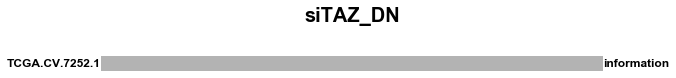

In [6]:
rank_features_against_references(features, refs, 'information', ref_type='categorical', output_directory=output_directory)

# NMF

In [ ]:
nmf_result = ccbal.analyze.nmf(features, [3], plot=True)

In [ ]:
ns, runtimes = ccbal.support.runtime(ccbal.information.information_coefficient, n_range=range(10))

In [ ]:
from scipy.stats import pearsonr
ns, runtimes = ccbal.support.runtime(pearsonr, n_range=range(10))

In [ ]:
# make_heatmap_panel is in the ccba/library/ccba.py
# make_heatmap_panel calls plot_heatmap_panel, which is in the ccba/library/visualize.py
# make_heatmap_panel computes IC of each features's row and the ref (target).
# In the future, we can add other computation within this function so it can compute P-Val and FDR as well.
make_heatmap_panel(features, ref, ['IC', 'P-Val'])

# XXX

In [ ]:
# Feature selection test with real data for IC, CMI diff, and CMI ratio association metrics
## Ranking 60 genes + target profile with respect to the activation profile of KRAS component 6 (BRAF/MAPK)



## Feature selection using Information Coefficient

start_time = time.time()

gct1 = read_gct('/Users/tamayo/UCSD_2015/signatures/paper2/analysis/top_hits.gct', fill_na=0)
gct2 = read_gct('/Users/tamayo/UCSD_2015/signatures/Onco-GPS/CCLE_RNAseq_KRAS_SALE_Late.No_HAEM.k_9.H.v1.gct', fill_na=0)

common_cols = list(set(gct1.columns) & set(gct2.columns))
A = gct1[common_cols]
B = gct2[common_cols]
target = pd.DataFrame(B.loc['KRAS_SALE_Late_Comp_C6_9'])
target = target.T

IC = np.zeros(A.shape[0])
for i in range(A.shape[0]):
    IC[i] = round(compute_information_coefficient(x=target.iloc[0,:], y=A.iloc[i,:]), 3)  
                
IC_order = list(np.argsort(IC, kind='quicksort'))
IC = IC[IC_order]
A_sorted = A.reindex(A.index[IC_order]) 

end_time = time.time() 
print("Feature selection time %s seconds " % (end_time - start_time))

IC_val = pd.Series(IC[:A.shape[0]], name = "IC")
features = A_sorted.head(A.shape[0])
plot_heatmap_panel_v2(target, features, IC_val, "KRAS component 6 (BRAF/MAPK) co-essential genes")

## Feature selection using CMI diff

start_time = time.time()

gct1 = read_gct('/Users/tamayo/UCSD_2015/signatures/paper2/analysis/top_hits.gct', fill_na=0)
gct2 = read_gct('/Users/tamayo/UCSD_2015/signatures/Onco-GPS/CCLE_RNAseq_KRAS_SALE_Late.No_HAEM.k_9.H.v1.gct', fill_na=0)

common_cols = list(set(gct1.columns) & set(gct2.columns))
A = gct1[common_cols]
B = gct2[common_cols]
target = pd.DataFrame(B.loc['KRAS_SALE_Late_Comp_C6_9'])
target = target.T

CMI_diff_vals = np.zeros(A.shape[0])
for i in range(A.shape[0]):
    CMI_diff_vals[i] = round(CMI_diff(x=target.iloc[0,:], y=A.iloc[i,:]), 3)  
                
CMI_order = list(np.argsort(CMI_diff_vals, kind='quicksort'))
CMI_diff_vals = CMI_diff_vals[CMI_order]
A_sorted = A.reindex(A.index[CMI_order]) 

end_time = time.time() 
print("Feature selection time %s seconds " % (end_time - start_time))

CMI_val = pd.Series(CMI_diff_vals[:A.shape[0]], name = "CMI diff")
features = A_sorted.head(A.shape[0])
plot_heatmap_panel_v2(target, features, CMI_val, "KRAS component 6 (BRAF/MAPK) co-essential genes")

## Feature selection using CMI ratio

start_time = time.time()


gct1 = read_gct('/Users/tamayo/UCSD_2015/signatures/paper2/analysis/top_hits.gct', fill_na=0)
gct2 = read_gct('/Users/tamayo/UCSD_2015/signatures/Onco-GPS/CCLE_RNAseq_KRAS_SALE_Late.No_HAEM.k_9.H.v1.gct', fill_na=0)

common_cols = list(set(gct1.columns) & set(gct2.columns))
A = gct1[common_cols]
B = gct2[common_cols]
target = pd.DataFrame(B.loc['KRAS_SALE_Late_Comp_C6_9'])
target = target.T

CMI_ratio_vals = np.zeros(A.shape[0])
for i in range(A.shape[0]):
    CMI_ratio_vals[i] = round(CMI_ratio(x=target.iloc[0,:], y=A.iloc[i,:]), 3)  
                
CMI_order = list(np.argsort(CMI_ratio_vals, kind='quicksort'))
CMI_ratio_vals = CMI_ratio_vals[CMI_order]
A_sorted = A.reindex(A.index[CMI_order]) 

end_time = time.time() 
print("Feature selection time %s seconds " % (end_time - start_time))

CMI_val = pd.Series(CMI_ratio_vals[:A.shape[0]], name = "CMI ratio")
features = A_sorted.head(A.shape[0])

plot_heatmap_panel_v2(target, features, CMI_val, "KRAS component 6 (BRAF/MAPK) co-essential genes")